# This notebook aims at applying transfer learning

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [15]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode


def create_download_link(title="Download CSV file", filename="experiment/kaggle.csv"):
    df = pd.read_csv(filename)
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)



def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train_images', 'val_images']:
            if phase == 'train_images':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train_images'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train_images':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val_images' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val_images']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


# Loading data

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train_images': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_images': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = 'bird_dataset/'
experiment = 'experiment/'
training_path = os.path.join(data_dir, 'train_images')
bird_classes = os.listdir(training_path)
sample_class = np.random.choice(bird_classes)

# parameters
n_classes = len(bird_classes)
seed = 1
log_interval = 10

# Create experiment folder
if not os.path.isdir(experiment):
    os.makedirs(experiment)
    
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train_images', 'val_images']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train_images', 'val_images']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train_images', 'val_images']}
class_names = image_datasets['train_images'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize a few images

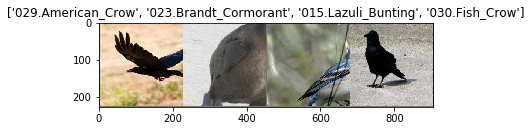

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train_images']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training

In [17]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, n_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train_images Loss: 2.3771 Acc: 0.2847
val_images Loss: 0.9695 Acc: 0.7184

Epoch 1/24
----------
train_images Loss: 1.5768 Acc: 0.5157
val_images Loss: 0.9762 Acc: 0.7184

Epoch 2/24
----------
train_images Loss: 1.3358 Acc: 0.5924
val_images Loss: 0.9254 Acc: 0.7087

Epoch 3/24
----------
train_images Loss: 1.2787 Acc: 0.6155
val_images Loss: 0.6915 Acc: 0.7767

Epoch 4/24
----------
train_images Loss: 1.1334 Acc: 0.6636
val_images Loss: 1.0173 Acc: 0.7282

Epoch 5/24
----------
train_images Loss: 1.0734 Acc: 0.6839
val_images Loss: 0.8421 Acc: 0.7670

Epoch 6/24
----------
train_images Loss: 0.9796 Acc: 0.7070
val_images Loss: 0.8491 Acc: 0.7767

Epoch 7/24
----------
train_images Loss: 0.8594 Acc: 0.7375
val_images Loss: 0.5506 Acc: 0.8447

Epoch 8/24
----------
train_images Loss: 0.7438 Acc: 0.7884
val_images Loss: 0.5604 Acc: 0.8447

Epoch 9/24
----------
train_images Loss: 0.8187 Acc: 0.7542
val_images Loss: 0.5842 Acc: 0.8544

Epoch 10/24
----------
train_i

In [ ]:
visualize_model(model_ft)